In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


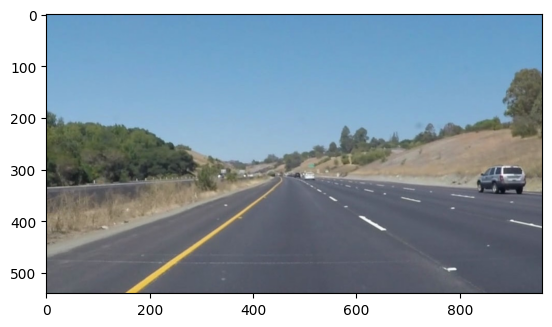

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidYellowCurve.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

In [3]:
import math

def grayscale(img):
    
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def draw_lines(img, lines, color=[255, 0, 0], thickness=15):
    
    
    if lines is not None:
        img_shape = img.shape
        right_lines = []
        left_lines = []
        
        left_lane_longest = {'length':0, 
                             'm':None, 
                             'b':None}   
        right_lane_longest = {'length':0, 
                              'm':None, 
                              'b':None}
    
        for line in lines:
            for x1,y1,x2,y2 in line:  
                if x2==x1:
                    continue
                slope = (y2-y1)/(x2-x1)  
                if slope > 0.4: 
                    right_lines.append([x1,y1])  
                    right_lines.append([x2,y2])
                elif slope < -0.4: 
                    left_lines.append([x1,y1]) 
                    left_lines.append([x2,y2])
           
        if len(right_lines) >= 2:
            for x1,y1 in right_lines[:-1]:
                for x2,y2 in right_lines[1:]: 
                    distance = np.sqrt((y2-y1)**2+(x2-x1)**2) 
                    if distance > left_lane_longest['length']:   
                        left_lane_longest['length'] = distance    
                        left_lane_longest['m']  = abs(float(y1 - y2)/(x1 - x2))
                        left_lane_longest['b']  = y1 - left_lane_longest['m']*x1

                
            y1 = img_shape[0]  
            x1 = int((y1 - left_lane_longest['b'])/left_lane_longest['m'])
            y2 = int(y1/1.6)
            x2 = int((y2 - left_lane_longest['b'])/left_lane_longest['m'])
            cv2.line(img, (x1, y1), (x2, y2), color, thickness) 

        if len(left_lines) >= 2:
            for x1,y1 in left_lines[:-1]:
                for x2,y2 in left_lines[1:]:
                    distance = np.sqrt((y2-y1)**2+(x2-x1)**2)
                    if distance > right_lane_longest['length']:
                        right_lane_longest['length'] = distance
                        right_lane_longest['m']  = -abs(float(y1 - y2)/(x1 - x2))
                        right_lane_longest['b']  = y1 - right_lane_longest['m']*x1
                        
            y1 = img_shape[0]
            x1 = int((y1 - right_lane_longest['b'])/right_lane_longest['m'])
            y2 = int(y1/1.6)
            x2 = int((y2 - right_lane_longest['b'])/right_lane_longest['m'])
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)  
   
            


def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    
    return cv2.addWeighted(initial_img, α, img, β, γ)



In [4]:
import os
array = os.listdir("test_images/")

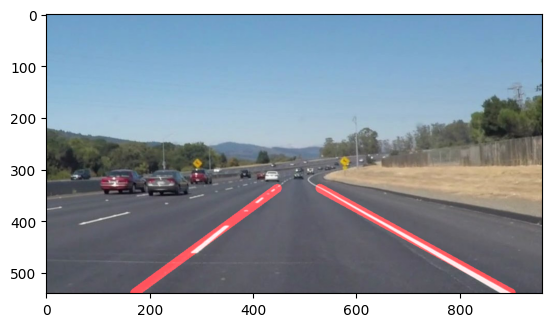

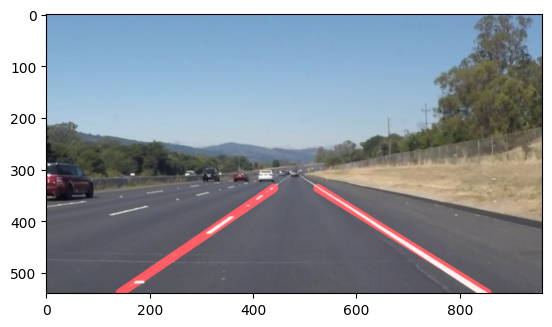

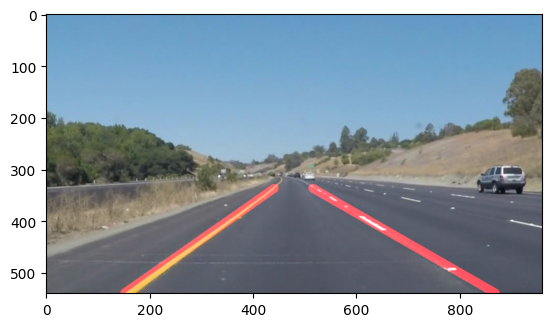

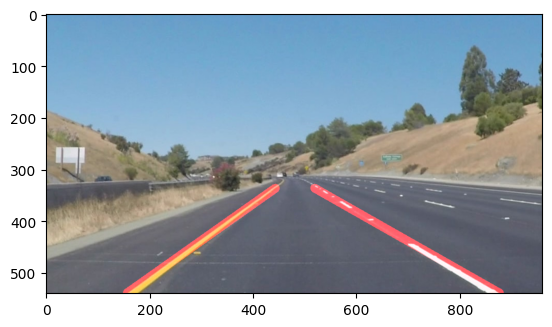

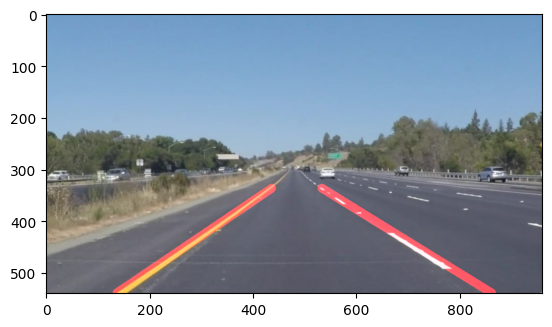

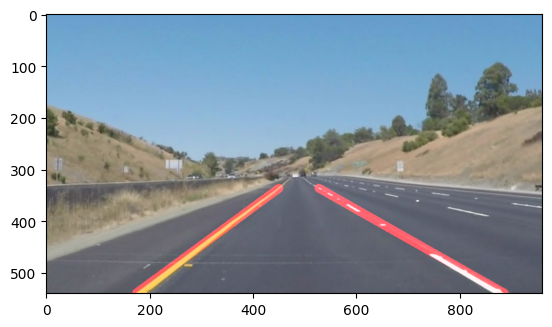

In [5]:

result_images = []
for image in array:
    initial_image= mpimg.imread('test_images/'+image)  
    image= np.copy(initial_image)
    gray = grayscale(image)
    kernel_size = 5
    blur_gray = gaussian_blur(gray, kernel_size)
    low_threshold = 50
    high_threshold = 150
    edge_image = canny(blur_gray, low_threshold, high_threshold)
    imshape = image.shape
    vertices = np.array([[(0,imshape[0]),(480, 320), (510, 320), (imshape[1],imshape[0])]], dtype=np.int32)
    image_after_masking = region_of_interest(edge_image, vertices)
    rho = 1
    theta = np.pi/180 
    threshold = 20    
    min_line_len = 20
    max_line_gap = 300 
    line_image = hough_lines(image_after_masking, rho, theta, threshold, min_line_len, max_line_gap)
    result_image = weighted_img(line_image, image, α=1.0, β=0.95, γ=0.)
    result_images.append(result_image)

for image in result_images: 
    plt.figure()
    plt.imshow(image)



In [6]:

from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [7]:
def process_image(image):
    
    initial_image = np.copy(image)
    gray = grayscale(initial_image)
    kernel_size = 5
    blur_gray = gaussian_blur(gray, kernel_size)
    low_threshold = 50
    high_threshold = 150
    edge_image = canny(blur_gray, low_threshold, high_threshold)
    imshape = image.shape
    vertices = np.array([[(0,imshape[0]),(480, 320), (510, 320), (imshape[1],imshape[0])]], dtype=np.int32)
    image_after_masking = region_of_interest(edge_image, vertices)
    rho = 1
    theta = np.pi/180 
    threshold = 20    
    min_line_len = 20
    max_line_gap = 300 
    line_image = hough_lines(image_after_masking, rho, theta, threshold, min_line_len, max_line_gap)
    result_image = weighted_img(line_image, image, α=1.0, β=0.95, γ=0.)
    return result_image

In [8]:
white_output = 'test_videos_output/solidWhiteRight.mp4'

clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) 
%time white_clip.write_videofile(white_output, audio=False)

Moviepy - Building video test_videos_output/solidWhiteRight.mp4.
Moviepy - Writing video test_videos_output/solidWhiteRight.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/solidWhiteRight.mp4
CPU times: total: 4.72 s
Wall time: 4.19 s


In [9]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [10]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'

clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

Moviepy - Building video test_videos_output/solidYellowLeft.mp4.
Moviepy - Writing video test_videos_output/solidYellowLeft.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/solidYellowLeft.mp4
CPU times: total: 15.8 s
Wall time: 11.6 s


In [12]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

In [13]:
challenge_output = 'test_videos_output/challenge.mp4'

clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

Moviepy - Building video test_videos_output/challenge.mp4.
Moviepy - Writing video test_videos_output/challenge.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/challenge.mp4
CPU times: total: 11.8 s
Wall time: 9.39 s


In [14]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))